In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

______________________________

In [2]:
network = 'tarbase'
target_homology = 'WGD'
remove_pre_2R = False

In [3]:
if target_homology == 'WGD':
	file_path_1 = f'./output/{network}_om.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.tsv'
elif target_homology == 'SSD':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.tsv'
else:
	raise ValueError("target_homology must be either 'WGD' or 'SSD'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [4]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[8, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

# test
mirna_lno_dict['MIRLET7E'][0]

'Bilateria'

In [5]:
df_wgd = df_1
df_ssd = df_2

In [6]:
print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  1383


In [7]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

if remove_pre_2R:
	df_ssd = df_ssd[~(df_ssd["miRNA_1"].apply(all_clades_in_pre2R) & df_ssd["miRNA_2"].apply(all_clades_in_pre2R))]

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  1383


In [8]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd = remove_mirna_pairs(df_ssd, df_wgd)

In [9]:
print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd))

Number of WGD pairs after removing miRNA pairs from SSD:  113
Number of SSD pairs after removing miRNA pairs from SSD:  1271


In [10]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_bifan" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

df_wgd = remove_sigma_err(df_wgd)
df_ssd = remove_sigma_err(df_ssd)

In [11]:
df_wgd_zscores = df_wgd['Z-score'].astype(float)
df_ssd_zscores = df_ssd['Z-score'].astype(float)

In [12]:
df_wgd_nbifan = df_wgd['n_relevant_bifan'].astype(int)
df_ssd_nbifan = df_ssd['n_relevant_bifan'].astype(int)

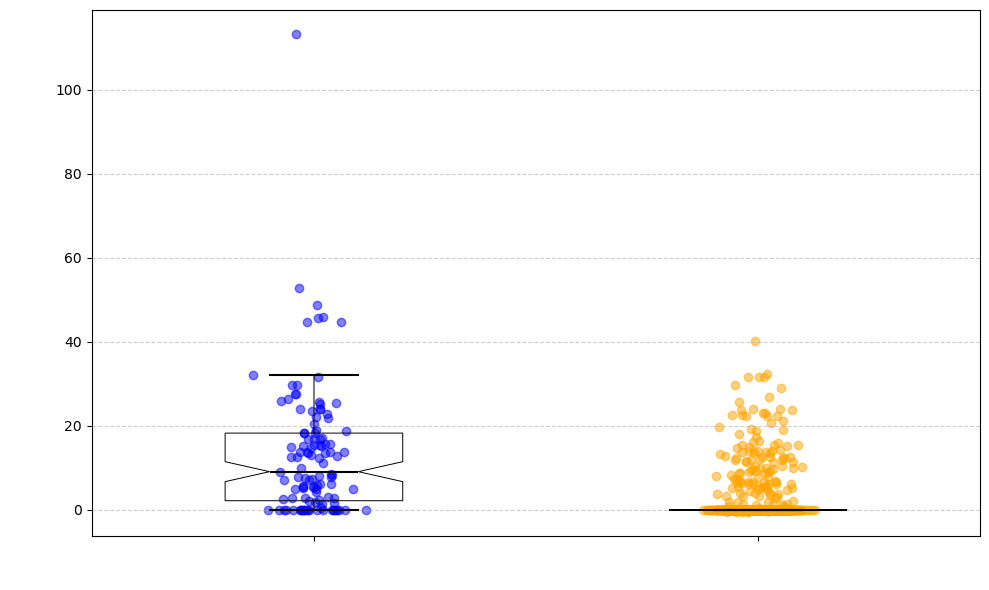

Number of WGD pairs:  113
Number of SSD pairs:  1270


In [13]:
# Sample sizes
n_wgd = len(df_wgd_zscores)
n_ssd = len(df_ssd_zscores)

# Jittered x positions
x_wgd = np.random.normal(0, 0.04, size=n_wgd)
x_ssd = np.random.normal(1, 0.04, size=n_ssd)

plt.figure(figsize=(10, 6))

# Boxplot with transparent fill and notches
box = plt.boxplot(
    [df_wgd_zscores, df_ssd_zscores],
    positions=[0, 1],
    widths=0.4,
    notch=True,
    patch_artist=True,
    showfliers=False
)

# Make boxes transparent
for patch in box['boxes']:
	patch.set_facecolor('none')
	patch.set_edgecolor('black')
	patch.set_linewidth(0.7)

# Customize other boxplot parts
for element in ['medians', 'whiskers', 'caps']:
    for line in box[element]:
        line.set_color('black')
        line.set_linewidth(1.5)
        # width of the whiskers
        if element == 'whiskers':
            line.set_alpha(0.5)

# Jittered dots
plt.scatter(x_wgd, df_wgd_zscores, alpha=0.5, color='blue', label='WGD')
plt.scatter(x_ssd, df_ssd_zscores, alpha=0.5, color='orange', label='SSD')

# Labels
plt.xticks([0, 1], [f' ', f' '], fontsize=25)
plt.ylabel(' ', fontsize=30)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

In [14]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_zscores, df_ssd_zscores)
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS statistic: 0.6828862100202077, p-value: 5.753676624595347e-48


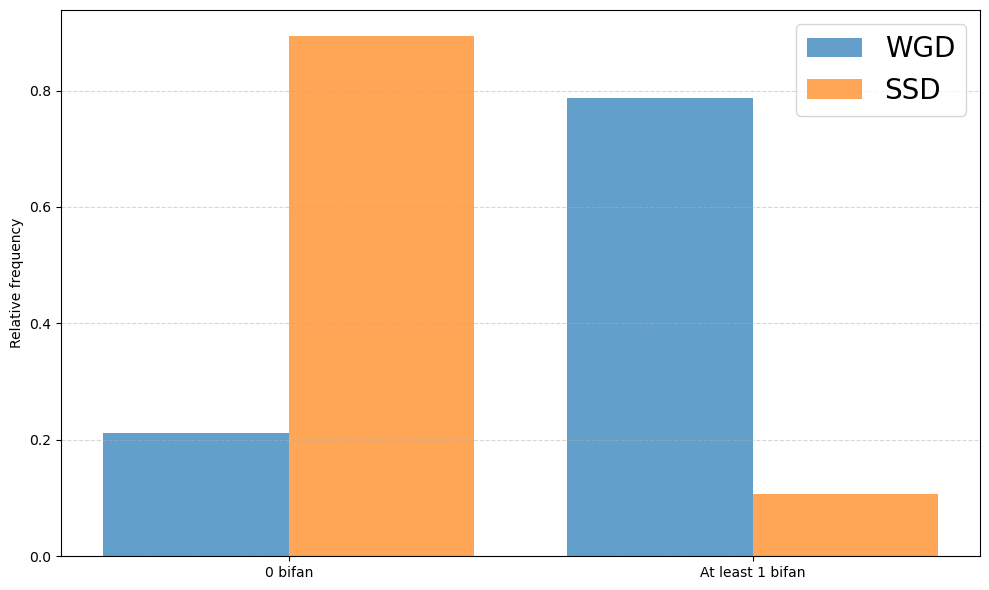

In [15]:
def bin_bifans(count):
    if count == 0:
        return '0'
    else:
        return 'At least 1 bifan'

# Bin the counts
wgd_binned = pd.Series(df_wgd_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(['0', 'At least 1 bifan'], fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(['0', 'At least 1 bifan'], fill_value=0)

# Plot
labels = ['0 bifan', 'At least 1 bifan']
x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels)
plt.xlabel('')
plt.ylabel('Relative frequency')
plt.title('')
plt.legend(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [16]:
# print the SSD pairs with Z-score > 3
df_ssd_high_z = df_ssd[df_ssd['Z-score'].astype(float) > 1]
df_ssd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
8,MIR10A,MIR125A,272,306,22,0.035,0.183780,1,35,5.250850271282601,2.477684724055962e-12
34,MIR106A,MIR18A,538,238,31,0.085,0.285963,1,83,3.1997114666617805,2.032237575444462e-06
35,MIR106A,MIR18B,538,135,19,0.026,0.159135,1,26,6.120583179856185,1.5543122344752192e-15
36,MIR106A,MIR20A,538,927,299,0.918,0.961913,8,0,7.362414658154365,5.555525253164717e-06
37,MIR106A,MIR20B,538,366,201,0.205,0.461492,3,4,6.056441110871285,2.523811826193878e-09
...,...,...,...,...,...,...,...,...,...,...,...
1377,MIRLET7F1,MIRLET7F2,543,519,488,0.357,0.594602,18,0,29.67197122409226,0.0
1378,MIRLET7F1,MIRLET7G,543,620,453,0.538,0.744685,16,0,20.763136767861326,0.0
1379,MIRLET7F1,MIRLET7I,543,478,436,0.324,0.592473,14,0,23.082916827666825,0.0
1380,MIRLET7F2,MIRLET7G,519,620,453,0.466,0.674421,16,0,23.033082636982474,0.0


In [17]:
df_wgd_high_z = df_wgd[df_wgd['Z-score'].astype(float) > 3]
df_wgd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
1,MIR103A1,MIR103A2,950,1075,950,2.990,1.744104,33,0,17.20653923003011,3.394947e-09
2,MIR103A1,MIR107,950,959,927,2.576,1.635917,30,0,16.763688015784837,2.413952e-09
3,MIR103A2,MIR107,1075,959,930,3.009,1.730005,30,0,15.60168458158699,1.290864e-07
4,MIR106A,MIR106B,538,398,205,0.214,0.456294,3,0,6.105715689216075,3.382723e-09
5,MIR106A,MIR17,538,1373,308,1.649,1.312173,9,0,5.602155986091695,6.950639e-03
...,...,...,...,...,...,...,...,...,...,...,...
106,MIRLET7B,MIRLET7F1,599,543,456,0.465,0.686130,13,0,18.269120581480326,0.000000e+00
107,MIRLET7A2,MIRLET7C,926,328,303,0.368,0.620142,6,0,9.0817921273447,8.987255e-12
108,MIRLET7A2,MIRLET7E,926,355,262,0.486,0.744180,5,1,6.065736085318966,8.317223e-07
109,MIRLET7C,MIRLET7E,328,355,247,0.085,0.289439,5,0,16.981118940678478,0.000000e+00
